In [1]:
file_Name = "BioFire v2 (423738) vs BioFire v1 (423744)"
test_for = "SARS-Covid-19"
test_type = "Molecular"
test_Ref = "BioFire v1 (423744)"
test_New = "BioFire v2 (423738)"

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

from statsmodels.stats.proportion import proportion_confint 
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.inter_rater import cohens_kappa

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle


In [3]:
data = pd.read_excel("BioFire_V2_vs_V1/Biofire V1 vs V2.xlsx") 
#remove na if any 
data.dropna(inplace=True, subset=['Ref', 'Test'])

renameDict = {'N': 'NEGATIVE',
              'P': 'POSITIVE', 
             'POS': 'POSITIVE', 
             'NEG': 'NEGATIVE',
             'REACTIVE': 'POSITIVE',
             'NON REACTIVE': 'NEGATIVE',
             'PRESUMPTIVE POSITIVE': 'POSITIVE'}

data.replace(renameDict, inplace=True)
# remove things not positive nor negative
data = data[(data['Ref'] == 'POSITIVE') |
           (data['Ref'] == 'NEGATIVE')]

data = data[(data['Test'] == 'POSITIVE') |
           (data['Test'] == 'NEGATIVE')]

data

,Unnamed: 0,Ref,Test,Confirmation test
0,HU00856796,NEGATIVE,NEGATIVE,NaN
1,HU00856788,NEGATIVE,NEGATIVE,NaN
2,HU00857665,NEGATIVE,POSITIVE,Negative on Thermo
3,HU00858492,NEGATIVE,NEGATIVE,NaN
4,HU00858485,NEGATIVE,NEGATIVE,NaN
5,HU00862519,NEGATIVE,NEGATIVE,NaN
6,HU00862584,NEGATIVE,NEGATIVE,NaN
7,HU00862872,NEGATIVE,NEGATIVE,NaN
8,HU00865522,NEGATIVE,NEGATIVE,NaN
9,JB00679466,NEGATIVE,POSITIVE,Negative on Roche


In [4]:
data.shape

(40, 4)

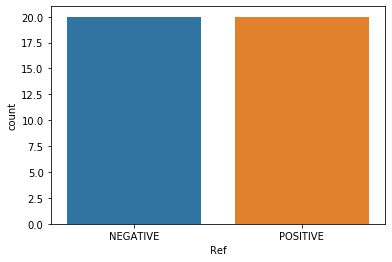

In [5]:
sns.countplot(x='Ref', data=data);

In [6]:
confMatrix = pd.crosstab(data['Ref'], data['Test'], 
                         rownames=['Reference'], colnames=['New Test'], 
                         margins=True, margins_name='Total')

In [7]:
confMatrix

New Test,NEGATIVE,POSITIVE,Total
Reference,,,
NEGATIVE,18,2,20
POSITIVE,2,18,20
Total,20,20,40


In [8]:
data['Agree'] = data['Ref'] == data['Test']
Agreement = np.round(data['Agree'].sum() / data.shape[0] * 100, 1)

wilson_score = proportion_confint(data['Agree'].sum(), 
                  data.shape[0],
                  alpha=0.05,
                  method='wilson')
wilsonL = np.round(wilson_score[0]  * 100, 1)
wilsonU = np.round(wilson_score[1]  * 100, 1)

AgreementP = np.round(data[data['Ref'] == 'POSITIVE']['Agree'].sum() / data[data['Ref'] == 'POSITIVE'].shape[0] * 100, 1)
AgreementN = np.round(data[data['Ref'] == 'NEGATIVE']['Agree'].sum() / data[data['Ref'] == 'NEGATIVE'].shape[0] * 100, 1)

In [9]:
t = np.matrix(confMatrix.iloc[0:2, 0:2])
Test_Ref = confMatrix.iloc[1,0] 
Test_Ref
Ref_Test = confMatrix.iloc[0,1]
Ref_Test
homogeneity = mcnemar(t, exact=True, correction=True)

ck = cohens_kappa(t)

state = 'FAILS'
if homogeneity.pvalue < 0.05:
    state = 'FAILS'
else:
    state = 'PASSES'
    


In [10]:
t1 = (f'Agreement : {Agreement}% ({wilsonL}% to {wilsonU}%)*')
t2 = (f'Positive Agreement : {AgreementP}%')
t3 = (f'Negative Agreement : {AgreementN}%')
t4 = ('*95% confidance interval calculated by the Wilson score method')

t5 = ('McNemar test of symmetry:')
t6 = (f'Test < Reference : {Test_Ref} ({np.round(Test_Ref/confMatrix.iloc[2,2]*100, 1)}%)')
t7 = (f'Test > Reference : {Ref_Test} ({np.round(Ref_Test/confMatrix.iloc[2,2]*100, 1)}%)')
t8 = (f'Symmetry test {state} p = {homogeneity.pvalue} (Exact Test)')

t9 = (f"Cohen's Kappa {np.round(ck['kappa']*100, 1)}% ({np.round(ck['kappa_low'], 2)*100}% to {np.round(ck['kappa_upp'], 2)*100}%)")
t10 = ('Kappa is the portion of agreement above what is expected by chance.')
t11 = ('The rule of thumb is that Kappa > 75% indicates "high" agreement.')

s=""


stats = list([t1, t2, t3, t4, s, t5, t6, t7, t8, s, t9, t10, t11])


In [11]:
data = confMatrix.values.tolist()
cols = ['', 'NEGATIVE', 'POSITIVE', 'Total']
rows = ['NEGATIVE', 'POSITIVE', 'Total']
i = 0
for item in data:
    item.insert(0, rows[i])
    i += 1
    
    
data = [cols] +  data
data

[['', 'NEGATIVE', 'POSITIVE', 'Total'],
 ['NEGATIVE', 18, 2, 20],
 ['POSITIVE', 2, 18, 20],
 ['Total', 20, 20, 40]]

In [12]:
c = canvas.Canvas(f"{file_Name}.pdf", pagesize=A4)
c.setLineWidth(0.3)
c.setFont('Helvetica', 14)

c.drawString(30,750, f'{file_Name} for {test_for} {test_type} test')
c.setFont('Helvetica', 10)
c.drawString(30, 730, f'Date: {datetime.date.today()}')
c.line(30,745,560,745)
c.line(30,743,560,743)

c.setFont('Helvetica', 10)
c.drawString(30, 710, f'Reference: {test_Ref}')
c.drawString(30, 695, f'New Test: {test_New} ')

c.setFont('Helvetica', 12)
c.drawString(30, 665, 'Statistics')
c.line(30,660,80,660) 


c.setFont('Helvetica', 8)
h = 640
l = 50
for t in stats:    
    t = t.split(" : ")
    if len(t) == 2:
        c.drawString(l, h, t[0])
        c.drawString(l+90, h, t[1])
    else:
        c.drawString(l, h, t[0])
    
    h = h - 11

c.setFont('Helvetica', 12)   
c.drawString(30, 470, 'Contingency table')
c.line(30,465,130,465)    

width = 400
height = 100
x = 80
y = 360

t=Table(data)
t.setStyle(TableStyle([('BACKGROUND',(1,1),(1,1),colors.lightblue),
                      ('BACKGROUND',(2,2),(2,2),colors.lightblue),
                      ('BACKGROUND',(2,1),(2,1),colors.lightpink),
                      ('BACKGROUND',(1,2),(1,2),colors.lightpink),
                      ('ALIGN', (0,0), (3,3), 'CENTER'),
                      ('FONTSIZE',(0,0), (3,3), 7)]))

t.wrapOn(c, width, height)
t.drawOn(c, x, y)

c.setFont('Helvetica', 8) 
c.drawString(150, 440, 'REFERENCE')
c.line(140, 438, 210, 438)

c.drawString(55, 392, 'NEW')
c.line(80, 380,80, 412)

c.save()  
